# Projeto Final #

Ajudar a empresa Interconnect a prever sua taxa de churn, criando um modelo treinado que seja capaz de prever o comportamento de futuros clientes.

Principais Passos (Primeira Avaliação)
- Estudar os Dados e verificar cada uma das tabelas (temos quatro tabelas ao total)
- Realizar a limpeza de colunas desnecessárias e dados ausentes, verificar os tipos de dados e criar uma Master Table ara os modelos
- Realizar uma análise exploratória buscando entender o comportamento geral dos clientes e o impacto que certas colunas podem ter nos nossos dados
- Treinar e avaliar os modelos
- Preparar minhas conclusões

## Planejamento de Trabalho

Temos um trabalho que, há uma primeira vista, precisa de uma prepração de dados mais longa, pela quantidade de Daframes e pela quantidade de variáveis categóricas do tipo object. MInha primeira ideia é binarizar todas as informações possíveis e verificar a necessidade de todas as colunas, para chegarmos com um dataframe final mais limpo e simples possível. Minha AED vai ser dividida em cerca de 7 ou 8 passos, buscando entender qualquer característica dos dados que possa atrapalhar o modelo e entender padrões de perfil e comportamento de clientes, para fornecer alguns insights à empresa. Depois, vamos preparar os dados para os modelos, levando em consideração as conclusões da AED. Quero treinar cerca de 5 modelos como regressão, floresta e modelos baseados em boost, porque teremos um bom agrupamento de modelos mais simples e modelos mais robustos. Queremos atingir uma AUC ROC de 0.75, mas vamos aplicar técnicas como validação cruzada e gridsearch para buscar o melhor valor possível.

## Importando Bibliotecas e Lendo Arquivos ##

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Preparando os Dados para a AED

In [3]:
for name, df in zip(['Contract', 'Internet', 'Personal', 'Phone'], 
                    [df_contract, df_internet, df_personal, df_phone]):
    print(f"\n===== {name} =====")
    display(df.head())
    display(df.info())


===== Contract =====


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


===== Internet =====


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


===== Personal =====


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


===== Phone =====


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Aqui, nós já temos uma tonelada de informações interessantes sobre nosas tabelas. O Dataframe contratos será o dataframe principal, no qual juntarmemos todos os outros pela coluna de id. Ela contém dados de todos os clientes e tem a nossa variável objetivo, que será um True or False a ser extraído da coluna EndDate. Em um primeiro momento, parece que não há dados ausentes, mas a coluna TotalCharges, que parece conter dados float, está como object. Isso indica qe provavelmente há colunas sem informação que não apresentam NaN e forçam o método info a itnerpretá-las como dados presentes. Vamos investigar isso. Vamos trocar begin_date de Object para datetime. 

O segundo dataframe traz informações sobre qual serviço de internet o cliente utiliza. Faz sentido ela ser menor, o que indica que nem todos os clientes tem internet. Vale verificar quais colunas do tipo object apresentam apenas Yes ou No como resposta, porque esas podem ser convertidas para o tipo booleano sem exigir o One-Hot-Encoding. 

O dataframe Personal traz informações pessoais sobre cada cliente. Ele possui o mesmo número de entradas que o dataframe Contract, o que é exatamente o que esperávamos ver. Pode ser interessante verificar, na AED, se alguma condição de gênero, idade ou família pode levar a um churn maior. Esse é mais um dataframe que pode ser convertido para booleano se todas as respostas forem binárias.

O último dataframe só nos traz a informação se cada cliente tem mais de uma linha. Ele é menor, pela mesma razão que o dataframe de internet, mas aplicando a lógica contrária. Nem todos os clientes tem telefone. Alguns podem usar apenas a internet. Vamos verificar se as respostas são apenas Yes ou No, seguindo a mesma ideia das outras tabelas.

### Modificando as Tabelas

#### df_contracts

In [4]:
def camel_to_snake(name):
    return re.sub(r'(?<=[a-z])(?=[A-Z])', '_', name).lower()

df_contract.columns = [camel_to_snake(col) for col in df_contract.columns]

In [5]:
df_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [6]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])

In [7]:
df_contract['begin_date'].dtypes

dtype('<M8[ns]')

Aqui, adotamos a snake_case pros títulos das colunas, para facilitar o trabalho. Por fim, convertemos begin_datye para datetime. Agora, vamos verificar o que está acontecendo com a coluna 'total_charges'. 

In [8]:
df_contract['total_charges'].value_counts(dropna=False).head(20)

         11
20.2     11
19.75     9
19.9      8
19.65     8
20.05     8
45.3      7
19.55     7
20.25     6
20.15     6
19.45     6
20.45     5
20.3      5
20.4      4
75.3      4
49.9      4
19.3      4
70.6      4
69.95     4
74.7      4
Name: total_charges, dtype: int64

In [9]:
df_contract[df_contract['total_charges'].str.strip() == '']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [10]:
df_contract['begin_date'].value_counts()

2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64

In [11]:
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')
df_contract['total_charges'] = df_contract['total_charges'].fillna(0)

In [12]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Confirmamos que exsitem 11 valores ausentes e que eles não estão presentes porque os clentes acabaram de entrar pra operadora e ainda não tem cobranças. Por isso, vamos preenchê-los com 0, mudar o tipo de dado para float. Além disso, agora, vamos verificar quais colunas do tipo Object tem apenas respostas binárias, porque essas podem ser convertidas para bool sem o uso do one-hot-encoding criando mais colunas

In [13]:
for col in df_contract.select_dtypes(include='object').columns:
    print(f"\n{col}:")
    print(df_contract[col].value_counts())


customer_id:
8818-DOPVL    1
5067-XJQFU    1
1567-DSCIC    1
8220-OCUFY    1
8189-HBVRW    1
             ..
6736-DHUQI    1
7777-UNYHB    1
2923-ARZLG    1
8063-GBATB    1
1702-CCFNJ    1
Name: customer_id, Length: 7043, dtype: int64

end_date:
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

type:
Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

paperless_billing:
Yes    4171
No     2872
Name: paperless_billing, dtype: int64

payment_method:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64


Em temoria, podemos transformar papperless_billing. Mas isso gerou um problema, já que o método criou NaN. Um value_counts() Não retornou valores estranhos, então deve ser espaços extras que o map não processa. Vamos limpar esses espaços, fazer o mapeamento e verificar os ausentes. Retornando zerado, nós podemos converter para bool.

In [14]:
df_contract['paperless_billing'] = df_contract['paperless_billing'].str.strip()
df_contract['paperless_billing'] = df_contract['paperless_billing'].map({'Yes': 1, 'No': 0})

In [15]:
df_contract['paperless_billing'].isna().sum()

0

In [16]:
df_contract['paperless_billing'] = df_contract['paperless_billing'].astype(bool)

##### Criando o Target

In [17]:
reference_date = pd.to_datetime('2020-02-01')

df_contract['end_date_clean'] = pd.to_datetime(
    df_contract['end_date'].replace('No', reference_date)
)

df_contract['time_of_contract_years'] = (
    (df_contract['end_date_clean'] - df_contract['begin_date']).dt.days / 365
).round(2)

df_contract['is_client'] = (df_contract['end_date'] == 'No').astype(int)

df_contract.drop(columns=['end_date', 'end_date_clean'], inplace=True)

cols = df_contract.columns.tolist()
cols.remove('is_client')
cols.remove('time_of_contract_years')
insert_at = cols.index('begin_date') + 1
cols = (
    cols[:insert_at]
    + ['is_client', 'time_of_contract_years']
    + cols[insert_at:]
)
df_contract = df_contract[cols]

df_contract.head()

,customer_id,begin_date,is_client,time_of_contract_years,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,1,0.08,Month-to-month,True,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,1,2.84,One year,False,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,0,0.17,Month-to-month,True,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,1,3.76,One year,False,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,0,0.17,Month-to-month,True,Electronic check,70.70,151.65


In [18]:
df_contract['is_client'].value_counts(normalize=True)

1    0.73463
0    0.26537
Name: is_client, dtype: float64

Criamos a nossa coluna target e já podemos atentar para o fato de que há um desequilíbrio nos dados. Lidaremos com isso mais pra frente. Esse código todo cria a nossa coluna target que eu chamei de "is_client", retornando 1 para sim e 0 para não. Exclui a coluna de final de contrato, porque, da forma como está, ela não é relevante, mas preserva a informação de quanto tempo de contrato cada cliente teve/tem, o que será uma informação valiosa para nossos modelos, com certeza. Toda essa alteração é necessária, porque tínhamos que prever um "no" de uma coluna object como targget. Alguns modelos podem lidar bem com variáveis categóricas como target, mas a mudança vai ajudar modelos como a regressão logística. Assim garantimos que não há perda de informação, que mesmo um humano visualiza e entende as informações e que nossos modelos vão tirarar as melhores conclusões

In [19]:
df_contract.isna().sum()

customer_id               0
begin_date                0
is_client                 0
time_of_contract_years    0
type                      0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
dtype: int64

Sem mais nenhum valor ausente, nosso trabalho com essa tabela está pronto. podemos nos virar para as próxias tabelas. 

#### df_personal

In [20]:
df_personal.columns = [camel_to_snake(col) for col in df_personal.columns]

In [21]:
for col in df_personal.select_dtypes(include='object').columns:
    print(f"\n{col}:")
    print(df_personal[col].value_counts())


customer_id:
8818-DOPVL    1
5067-XJQFU    1
1567-DSCIC    1
8220-OCUFY    1
8189-HBVRW    1
             ..
6736-DHUQI    1
7777-UNYHB    1
2923-ARZLG    1
8063-GBATB    1
1702-CCFNJ    1
Name: customer_id, Length: 7043, dtype: int64

gender:
Male      3555
Female    3488
Name: gender, dtype: int64

partner:
No     3641
Yes    3402
Name: partner, dtype: int64

dependents:
No     4933
Yes    2110
Name: dependents, dtype: int64


In [22]:
df_personal['gender'] = df_personal['gender'].str.strip().map({'Male': 1, 'Female': 0}).astype(int)
df_personal['partner'] = df_personal['partner'].str.strip().map({'Yes': 1, 'No': 0}).astype(bool)
df_personal['dependents'] = df_personal['dependents'].str.strip().map({'Yes': 1, 'No': 0}).astype(bool)

In [23]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   int64 
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   bool  
 4   dependents      7043 non-null   bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 179.0+ KB


In [24]:
df_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,0,0,True,False
1,5575-GNVDE,1,0,False,False
2,3668-QPYBK,1,0,False,False
3,7795-CFOCW,1,0,False,False
4,9237-HQITU,0,0,False,False


Não haviam dados ausentes para nos preocupar e tudo que precisamos verificar era a mudança de tipos de dados da tabela. Assim, nossos modelos poderão lidar com todas as colunas. Aqui, todas tinham respostas binárias, que foram substituídas por 0 ou 1/Tru ou False. 

ATENÇÃO:
df_personal['gender'] = male = 1, female 0

#### df_internet

Aqui, repetimos o processo. Temos apenas respostas binárias para todas as variáveis. Transformaremos tudo em 0 ou 1 para evitar OHE. Essa coluna é menor, o que criará valores faltantes quando fizermos o merge, mas tomaremos o cuidado de preenche-los com 0, representando false, que, seguindo a lógica até aqui, resolve nosso problema.

In [25]:
df_internet.columns = [camel_to_snake(col) for col in df_internet.columns]

In [26]:
for col in df_internet.select_dtypes(include='object').columns:
    print(f"\n{col}:")
    print(df_internet[col].value_counts(dropna=False))


customer_id:
8818-DOPVL    1
1833-VGRUM    1
5312-IRCFR    1
9903-LYSAB    1
7439-DKZTW    1
             ..
8313-NDOIA    1
7233-PAHHL    1
5599-HVLTW    1
9269-CQOOL    1
1702-CCFNJ    1
Name: customer_id, Length: 5517, dtype: int64

internet_service:
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

online_security:
No     3498
Yes    2019
Name: online_security, dtype: int64

online_backup:
No     3088
Yes    2429
Name: online_backup, dtype: int64

device_protection:
No     3095
Yes    2422
Name: device_protection, dtype: int64

tech_support:
No     3473
Yes    2044
Name: tech_support, dtype: int64

streaming_tv:
No     2810
Yes    2707
Name: streaming_tv, dtype: int64

streaming_movies:
No     2785
Yes    2732
Name: streaming_movies, dtype: int64


In [27]:
df_internet['internet_service'] = df_internet['internet_service'].str.strip().map({'Fiber optic': 1, 'DSL': 0}).astype(int)

binary_cols = [
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies'
]

for col in binary_cols:
    df_internet[col] = df_internet[col].str.strip().map({'Yes': 1, 'No': 0}).astype(int)

In [28]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   int64 
 2   online_security    5517 non-null   int64 
 3   online_backup      5517 non-null   int64 
 4   device_protection  5517 non-null   int64 
 5   tech_support       5517 non-null   int64 
 6   streaming_tv       5517 non-null   int64 
 7   streaming_movies   5517 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 344.9+ KB


#### df_phone

In [29]:
df_phone.columns = [camel_to_snake(col) for col in df_phone.columns]

In [30]:
for col in df_phone.select_dtypes(include='object').columns:
    print(f"\n{col}:")
    print(df_phone[col].value_counts(dropna=False))


customer_id:
8818-DOPVL    1
3976-HXHCE    1
3392-EHMNK    1
5515-AKOAJ    1
1178-PZGAB    1
             ..
9931-DCEZH    1
9600-UDOPK    1
1038-RQOST    1
5201-FRKKS    1
1702-CCFNJ    1
Name: customer_id, Length: 6361, dtype: int64

multiple_lines:
No     3390
Yes    2971
Name: multiple_lines, dtype: int64


In [31]:
df_phone['multiple_lines'] = df_phone['multiple_lines'].str.strip().map({'Yes': 1, 'No': 0}).astype(bool)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 56.0+ KB


A mesma lógica foi aplicada aqui. Nada mais a acrescentar. Vamos criar o dataframe final

#### Criando o master_df

In [33]:
master_df = df_contract.merge(df_personal, on='customer_id', how='left')

master_df = master_df.merge(df_internet, on='customer_id', how='left')

master_df = master_df.merge(df_phone, on='customer_id', how='left')

master_df.fillna(0, inplace=True)

In [34]:
master_df.head()

,customer_id,begin_date,is_client,time_of_contract_years,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,1,0.08,Month-to-month,True,Electronic check,29.85,29.85,0,...,True,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,5575-GNVDE,2017-04-01,1,2.84,One year,False,Mailed check,56.95,1889.50,1,...,False,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,False
2,3668-QPYBK,2019-10-01,0,0.17,Month-to-month,True,Mailed check,53.85,108.15,1,...,False,False,0.0,1.0,1.0,0.0,0.0,0.0,0.0,False
3,7795-CFOCW,2016-05-01,1,3.76,One year,False,Bank transfer (automatic),42.30,1840.75,1,...,False,False,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0
4,9237-HQITU,2019-09-01,0,0.17,Month-to-month,True,Electronic check,70.70,151.65,0,...,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [35]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7043 non-null   object        
 1   begin_date              7043 non-null   datetime64[ns]
 2   is_client               7043 non-null   int64         
 3   time_of_contract_years  7043 non-null   float64       
 4   type                    7043 non-null   object        
 5   paperless_billing       7043 non-null   bool          
 6   payment_method          7043 non-null   object        
 7   monthly_charges         7043 non-null   float64       
 8   total_charges           7043 non-null   float64       
 9   gender                  7043 non-null   int64         
 10  senior_citizen          7043 non-null   int64         
 11  partner                 7043 non-null   bool          
 12  dependents              7043 non-null   bool    

In [36]:
master_df['multiple_lines'] = master_df['multiple_lines'].astype(int)

In [37]:
master_df.head()

,customer_id,begin_date,is_client,time_of_contract_years,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,1,0.08,Month-to-month,True,Electronic check,29.85,29.85,0,...,True,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,5575-GNVDE,2017-04-01,1,2.84,One year,False,Mailed check,56.95,1889.50,1,...,False,False,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
2,3668-QPYBK,2019-10-01,0,0.17,Month-to-month,True,Mailed check,53.85,108.15,1,...,False,False,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
3,7795-CFOCW,2016-05-01,1,3.76,One year,False,Bank transfer (automatic),42.30,1840.75,1,...,False,False,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0
4,9237-HQITU,2019-09-01,0,0.17,Month-to-month,True,Electronic check,70.70,151.65,0,...,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [38]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7043 non-null   object        
 1   begin_date              7043 non-null   datetime64[ns]
 2   is_client               7043 non-null   int64         
 3   time_of_contract_years  7043 non-null   float64       
 4   type                    7043 non-null   object        
 5   paperless_billing       7043 non-null   bool          
 6   payment_method          7043 non-null   object        
 7   monthly_charges         7043 non-null   float64       
 8   total_charges           7043 non-null   float64       
 9   gender                  7043 non-null   int64         
 10  senior_citizen          7043 non-null   int64         
 11  partner                 7043 non-null   bool          
 12  dependents              7043 non-null   bool    

In [39]:
cols_to_int = [
    'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'
]

master_df[cols_to_int] = master_df[cols_to_int].astype(int)

In [40]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7043 non-null   object        
 1   begin_date              7043 non-null   datetime64[ns]
 2   is_client               7043 non-null   int64         
 3   time_of_contract_years  7043 non-null   float64       
 4   type                    7043 non-null   object        
 5   paperless_billing       7043 non-null   bool          
 6   payment_method          7043 non-null   object        
 7   monthly_charges         7043 non-null   float64       
 8   total_charges           7043 non-null   float64       
 9   gender                  7043 non-null   int64         
 10  senior_citizen          7043 non-null   int64         
 11  partner                 7043 non-null   bool          
 12  dependents              7043 non-null   bool    

Aqui, o merge acabou revertendo alguns tipos de dados. Essa pequena sequêcia de códigos foi necessária para corrigir tudo e garantir que os dados estivessem no tipo correto. Agora, vamos apenas eliminar a coluna de id, já que não precisamos mais dela. 

In [41]:
master_df.drop(columns='customer_id', inplace=True)

In [42]:
master_df.head()

,begin_date,is_client,time_of_contract_years,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,2020-01-01,1,0.08,Month-to-month,True,Electronic check,29.85,29.85,0,0,True,False,0,0,1,0,0,0,0,0
1,2017-04-01,1,2.84,One year,False,Mailed check,56.95,1889.50,1,0,False,False,0,1,0,1,0,0,0,0
2,2019-10-01,0,0.17,Month-to-month,True,Mailed check,53.85,108.15,1,0,False,False,0,1,1,0,0,0,0,0
3,2016-05-01,1,3.76,One year,False,Bank transfer (automatic),42.30,1840.75,1,0,False,False,0,1,0,1,1,0,0,0
4,2019-09-01,0,0.17,Month-to-month,True,Electronic check,70.70,151.65,0,0,False,False,1,0,0,0,0,0,0,0


Com isso, finalizamos a etapa de preparação de Dados. Já temos nosso mestre Jedi dos dataframes preparado para as próximas etapas. 

## Análise Exploratória de Dados

### A distribuição do Target

In [43]:
print(master_df['is_client'].value_counts())
print(master_df['is_client'].value_counts(normalize=True))

1    5174
0    1869
Name: is_client, dtype: int64
1    0.73463
0    0.26537
Name: is_client, dtype: float64


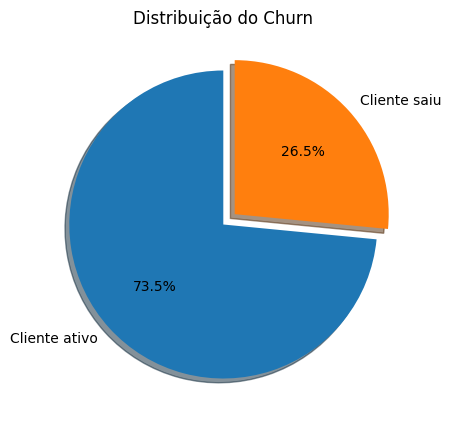

In [44]:
master_df['is_client'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Cliente ativo', 'Cliente saiu'],
    startangle=90,
    shadow=True,
    figsize=(5, 5),
    explode=(0, 0.1),
    title='Distribuição do Churn'
)
plt.ylabel('')
plt.show()

Reavaliamos a porcentagem de clientes que ficaram contra a porcentagem de cleintes que sairam. Aproveitei para plotar um gráfico e facilitar a visualização. Percebemos o desequilíbrio de classe, que, mantido como está, poderá causar problemas ao modelo. Vamos ter que aukmentar a quantidade de cleintes que sairam para deixar tudo equilibrado.

### Análise Temporal

In [45]:
temp_df = master_df.copy()
temp_df['ano_mes'] = temp_df['begin_date'].dt.to_period('M').astype(str)

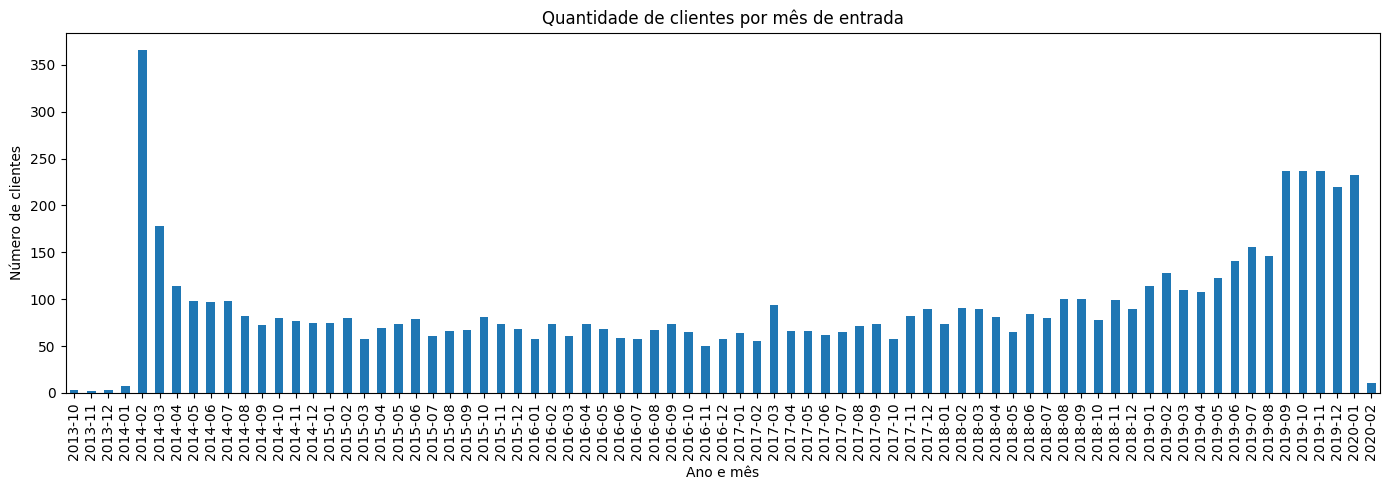

In [46]:
clientes_por_mes = temp_df['ano_mes'].value_counts().sort_index()
clientes_por_mes.plot(kind='bar', figsize=(14, 5), title='Quantidade de clientes por mês de entrada')

plt.xlabel('Ano e mês')
plt.ylabel('Número de clientes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

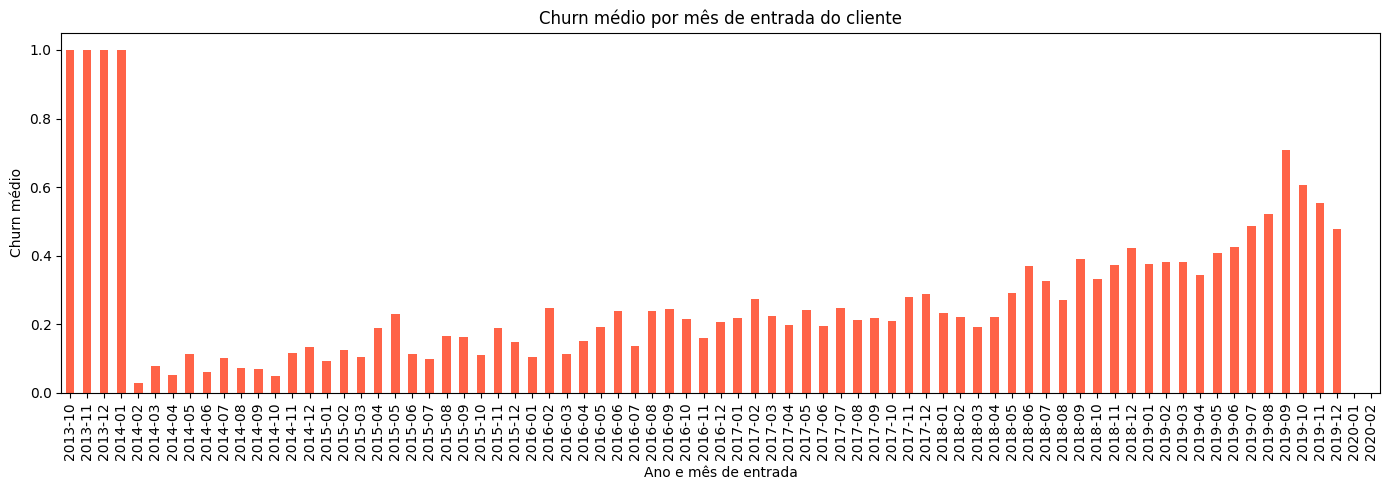

In [47]:
temp_df['has_churned'] = 1 - temp_df['is_client']

churn_by_month = temp_df.groupby('ano_mes')['has_churned'].mean()

churn_by_month.sort_index().plot(
    kind='bar',
    figsize=(14, 5),
    title='Churn médio por mês de entrada do cliente',
    color='tomato'
)

plt.xlabel('Ano e mês de entrada')
plt.ylabel('Churn médio')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Os dois gráficos já nos retornam informações valiosas. No primeiro, o pico em 2014 me parece artificial. Esse parece ser o momento que uma quantidade muito grande de clientes foi adicionada ao dataframe e não necessarimente entrou como cliente da empresa. Depois disso, a entrada de clientes segue bem estável, até começar a passar por um crescimento a partir de 2018. No meio de 2019, esse crescimento se acentua, mostrando o melhor momento da empresa no sentido de atrair novos clientes. A queda no último valor se deve ao fim da janela de observação. 

Já o segundo gráfico, que nos mostra o churn médio ao longo do tempo também é bem instrutivo. Os primeiros valores, atingindo a casa de 100% de churn, devem serr descosiderados. Isso acontece, porque, muito provavelmente, o database foi criado e abastecido com clientes que já não estavam mais com a empresa, cumprindo o objetivo de gerar dados, apenas. Após os primeiros registros artificiais, o churn médio se mantém relativamente estável ao longo dos anos, mas começa a crescer de forma visível a partir de 2018, com pico em 2019. 

Uma emrpesa que tem um aumento na atração de cleintes, seja por marketing agressivo ou promoções, tem uma tendência a perder mais clientes do que em momentos anteriores, porque ambos, o número de clientes satisfeitos e insatisfeitos tende a crescer para qualquer empresa. Mas esses dados também nos indicam que empresa pode ter uma capacidade ruim de manter os clientes satisfeitos com os serviços. Os dados também podem indicar que ela está atraindo o público errado.

Com relação à interpretação do modelo, será importante remover os dados dos quatro primeiros meses, porque ele vai gerar uma tendência errada aos algorítmos treinados. Além disso, como o churn médio cresce conforme as datas se aproximam do fim do período de observação, os modelos podem acabar gerando uma tendência de churn mais alta para clientes mais novos. 

Vamos começar removendo os quatro primeiros e os dois últmos meses do dataframe, porque eles tem valores irreais de churn, que podem adicionar extremo viés aos modelos. Depois, vamos recalcular a proporção de churn, para verificar o desbalanceamento mais uma vez.

In [48]:
filtered_df = master_df.copy()

filtered_df['ano_mes'] = filtered_df['begin_date'].dt.to_period('M')

filtered_df['has_churned'] = 1 - filtered_df['is_client']
churn_by_month = filtered_df.groupby('ano_mes')['has_churned'].mean()

meses_a_remover = churn_by_month.sort_index().index[:4].tolist() + churn_by_month.sort_index().index[-2:].tolist()

filtered_df = filtered_df[~filtered_df['ano_mes'].isin(meses_a_remover)]

filtered_df.drop(columns=['ano_mes', 'has_churned'], inplace=True)

print(meses_a_remover)
print(filtered_df.shape)

[Period('2013-10', 'M'), Period('2013-11', 'M'), Period('2013-12', 'M'), Period('2014-01', 'M'), Period('2020-01', 'M'), Period('2020-02', 'M')]
(6784, 20)


In [49]:
filtered_df.head()

,begin_date,is_client,time_of_contract_years,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1,2017-04-01,1,2.84,One year,False,Mailed check,56.95,1889.50,1,0,False,False,0,1,0,1,0,0,0,0
2,2019-10-01,0,0.17,Month-to-month,True,Mailed check,53.85,108.15,1,0,False,False,0,1,1,0,0,0,0,0
3,2016-05-01,1,3.76,One year,False,Bank transfer (automatic),42.30,1840.75,1,0,False,False,0,1,0,1,1,0,0,0
4,2019-09-01,0,0.17,Month-to-month,True,Electronic check,70.70,151.65,0,0,False,False,1,0,0,0,0,0,0,0
5,2019-03-01,0,0.67,Month-to-month,True,Electronic check,99.65,820.50,0,0,False,False,1,0,0,1,0,1,1,1


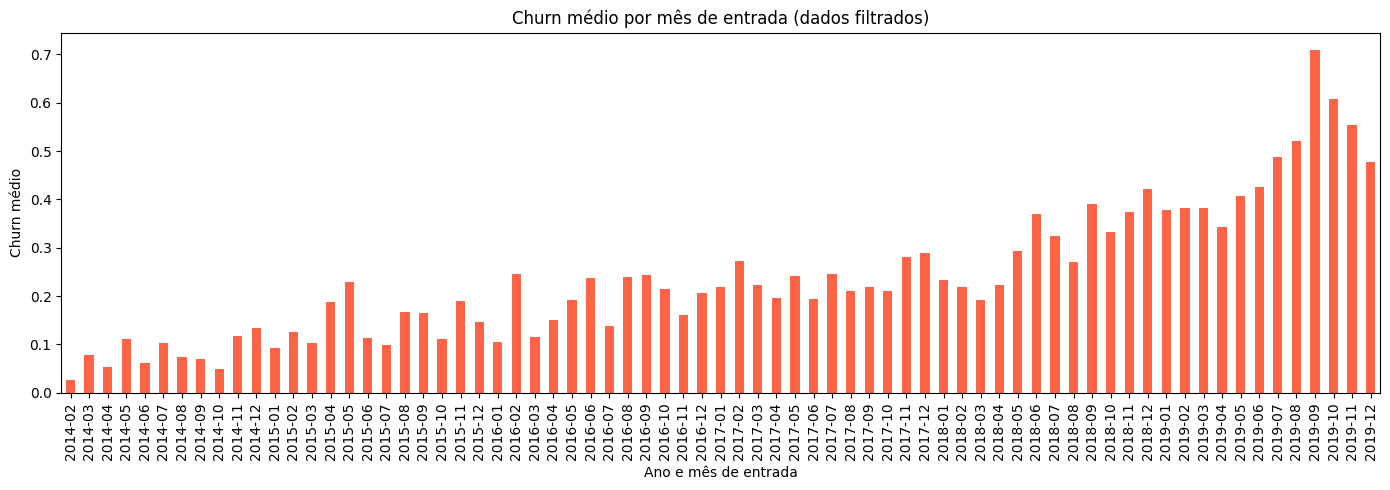

In [50]:
filtered_df['ano_mes'] = filtered_df['begin_date'].dt.to_period('M').astype(str)
filtered_df['has_churned'] = 1 - filtered_df['is_client']

churn_by_month_filtered = filtered_df.groupby('ano_mes')['has_churned'].mean()

churn_by_month_filtered.sort_index().plot(
    kind='bar',
    figsize=(14, 5),
    title='Churn médio por mês de entrada (dados filtrados)',
    color='tomato'
)

plt.xlabel('Ano e mês de entrada')
plt.ylabel('Churn médio')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Sem grandes mistérios aqui. Agora, podemos ver o mesmo gráfico do passo anterior, mas com os meses de valores distorcidos devidamente removidos. Isso vai ser muito importante para garantir que os modelos não tenham viés.

####  Verificando o Desbalanceamento no novo df

In [51]:
print(filtered_df['is_client'].value_counts(normalize=True))
print(filtered_df['is_client'].value_counts())

1    0.72671
0    0.27329
Name: is_client, dtype: float64
1    4930
0    1854
Name: is_client, dtype: int64


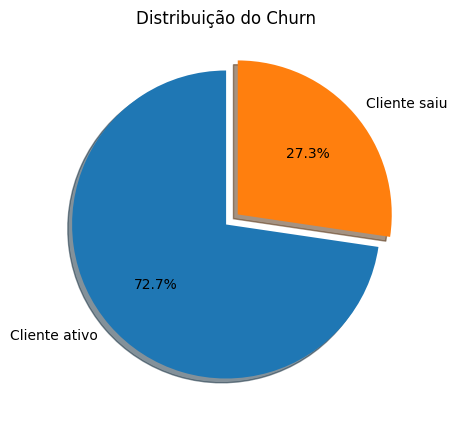

In [52]:
filtered_df['is_client'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Cliente ativo', 'Cliente saiu'],
    startangle=90,
    shadow=True,
    figsize=(5, 5),
    explode=(0, 0.1),
    title='Distribuição do Churn'
)
plt.ylabel('')
plt.show()

Não tivemos grandes mudanças por aqui. Podemos retomar o trabalho de onde paramos.

#### Retomando a Análise Temporal

#### Churn por tempo de contrato

Nessa análise, vamos dividir os clientes com contrato vigente em três grupos: Os que tem menos de um ano de casa são os clientes novos. Os que tem entre 1 e 2 são os antigos. Os que tem mais de dois anos são os muito antigos. Então, veremos a proporção de churn para cada grupo.

In [53]:
filtered_df.drop(columns=['has_churned', 'ano_mes'], inplace=True)

In [54]:
def categorizar_tempo_contrato(anos):
    if anos < 1:
        return 'Novo (<1 ano)'
    elif anos < 2:
        return 'Antigo (1-2 anos)'
    else:
        return 'Muito antigo (>2 anos)'

filtered_df['contract_age_group'] = filtered_df['time_of_contract_years'].apply(categorizar_tempo_contrato)

churn_por_grupo = filtered_df.groupby('contract_age_group')['is_client'].apply(lambda x: 1 - x.mean()).sort_index()

print(churn_por_grupo)

contract_age_group
Antigo (1-2 anos)         0.295129
Muito antigo (>2 anos)    0.139571
Novo (<1 ano)             0.547397
Name: is_client, dtype: float64


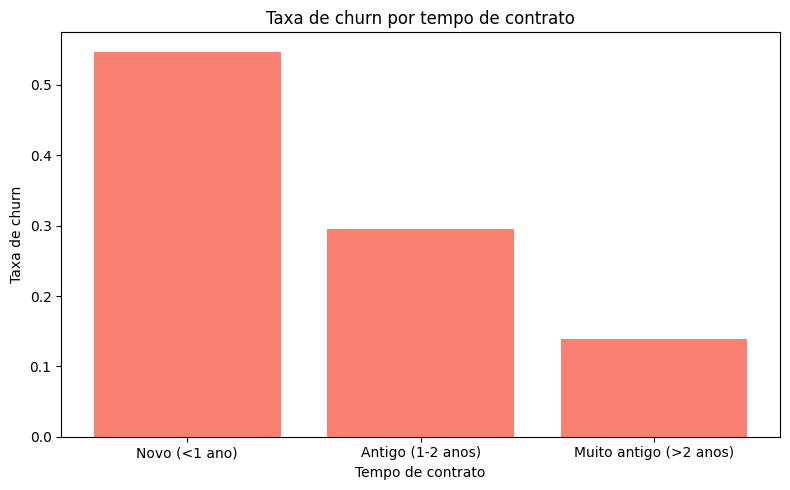

In [55]:
churn_por_grupo = (
    1 - filtered_df.groupby('contract_age_group')['is_client'].mean()
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(churn_por_grupo.index, churn_por_grupo.values, color='salmon')

plt.title('Taxa de churn por tempo de contrato')
plt.ylabel('Taxa de churn')
plt.xlabel('Tempo de contrato')
plt.tight_layout()
plt.show()

Aqui, percebemos um hurn alto para clientes novos. A empresa realmente está tendo problemas para segurar os clientes. Poderia ser interessante pensar em estratégias para segurar mais as pessoas. Os clientes antigos ainda saem bastante, mas em quantidade consideravelmente menor. Ao mesmo tempo, percebemos que a empresa vai muito bem em manter clientes já fidelizados. Para empresas de telecomunicações, a tendência é que os planos fiquem com preços e qualidade/velocidade do serviço defazada, mas, mesmo assim, a retenção aqui é boa. Isso pode indicar que a empresa vai bem nessa atualização para clientes antigos e trabalha bem o relacionamento com eles. Essa tendêcia será capturada pelos modelos, mas podemos seguir tranquilos.

In [56]:
filtered_df = filtered_df.drop(columns='contract_age_group')

### Perfil do Cliente

Agora, começaremos uma série de análises para identificar se quaisquer das características que a nossa tabela apresenta influencia na taxa do churn. O primeiro passo é verificar os insights dos dados trazidos pelo dataframe personal.

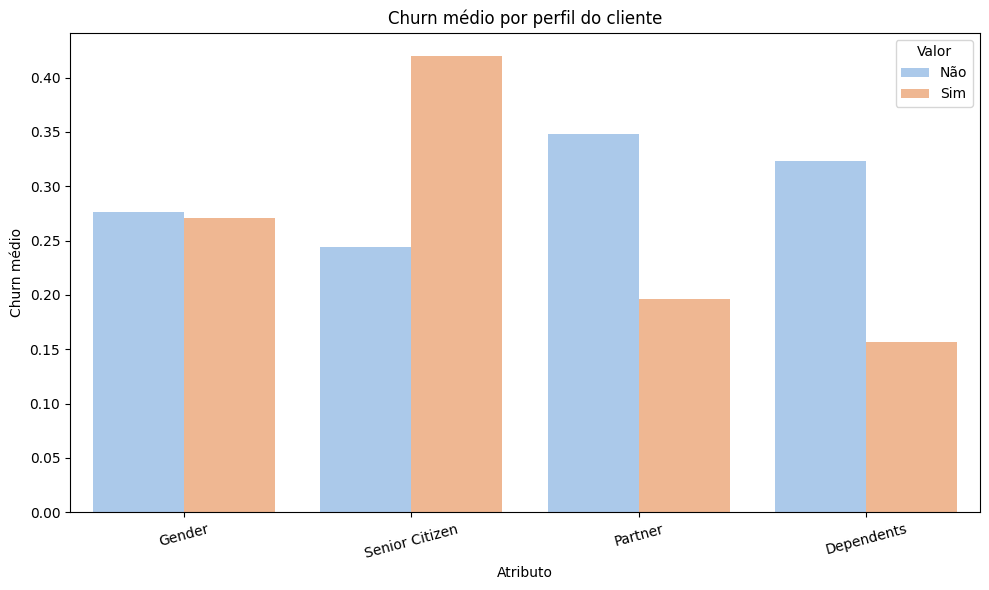

In [57]:
profile_cols = ['gender', 'senior_citizen', 'partner', 'dependents']

churn_profile_data = {'Atributo': [], 'Valor': [], 'Churn médio': []}

for col in profile_cols:
    for val, label in zip([0, 1], ['Não', 'Sim']):
        churn_mean = filtered_df[filtered_df[col] == val]['is_client'].apply(lambda x: 1 - x).mean()
        churn_profile_data['Atributo'].append(col.replace('_', ' ').title())
        churn_profile_data['Valor'].append(label)
        churn_profile_data['Churn médio'].append(churn_mean)

churn_profile_df = pd.DataFrame(churn_profile_data)

plt.figure(figsize=(10, 6))
sns.barplot(data=churn_profile_df, x='Atributo', y='Churn médio', hue='Valor', palette='pastel')
plt.title('Churn médio por perfil do cliente')
plt.ylabel('Churn médio')
plt.xlabel('Atributo')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Informações Contratuais

Ainda seguindo a lógica, vamos verificar o que as informações contratuais que temos nos revelam

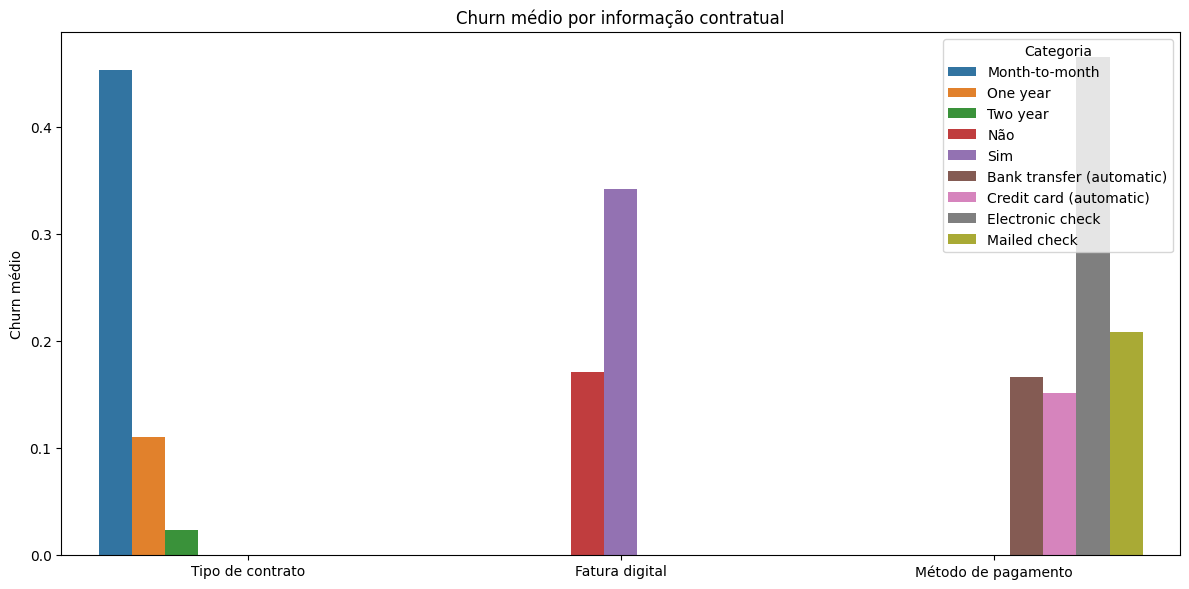

In [58]:
contract_columns = ['type', 'paperless_billing', 'payment_method']

contract_churn = pd.DataFrame()

for col in contract_columns:
    churn_mean = filtered_df.groupby(col)['is_client'].apply(lambda x: 1 - x.mean())
    churn_mean = churn_mean.reset_index()
    churn_mean.columns = ['Categoria', 'Churn médio']
    churn_mean['Coluna'] = col
    contract_churn = pd.concat([contract_churn, churn_mean], ignore_index=True)

contract_churn['Coluna'] = contract_churn['Coluna'].map({
    'type': 'Tipo de contrato',
    'paperless_billing': 'Fatura digital',
    'payment_method': 'Método de pagamento'
})

contract_churn['Categoria'] = contract_churn['Categoria'].replace({
    0: 'Não',
    1: 'Sim'
})

plt.figure(figsize=(12, 6))
sns.barplot(
    data=contract_churn,
    x='Coluna',
    y='Churn médio',
    hue='Categoria'
)

plt.title('Churn médio por informação contratual')
plt.ylabel('Churn médio')
plt.xlabel('')
plt.legend(title='Categoria')
plt.tight_layout()
plt.show()

Mais comportamentos interessantes a se discutir. No tipo de contrato, temos exatamente o que esperamos ver. Clientes que não tem contratos longos tendem a sair muito mais, porque não existe um prazo longo o multas a pagar, caso ele queira partir. Faz muito sentido que esse seja o tipo de contrato que mais tenha churn. O valor cai absurdamente quando temos um ano de contrato e cai ainda mais quando temos 2 anos de contrato. O desafio seria encontrar maneiras de manter os clientes que fecham de mês a mês.

As taxas de churn desse gráfico não são tão altas, o que é bom. Para a fatura digital, percebemos que os clientes saem quase duas vezes mais do que os que a recebem por outros meios. Essa é uma tendência difícil de explicar, mas é válida. Não me parece nada problemático.

Para o método de pagamento, vemos que o cheque eletrônico domina a quantidade de churn. Seguido muito de longe por mailed check, que está próximo das cobranças automáticas. O fato de as cobranças automáticas trazerem menos churn faz sentido, porque é de se imaginar que a necessidade de ativamente pagar exige uma atenção maior à empresa e suas cobranças constatemente. Esses momentos em que a empresa "vem a tona" para o cliente potencialmente isatisfeito pode levar à uma busca mais acentuada pelo cancelamento. Nas cobranças automáticas, isso acontece bem menos.

Para a empresa pode ser importante revisitar o processo de geração e envio de cheques eletrônicos. Algum problema ou dificuldade nesse serviço pode estar levando ao churn mais acentuado. Para os modelos, todos os padrões me parecem bons. 

### Serviços de Internet

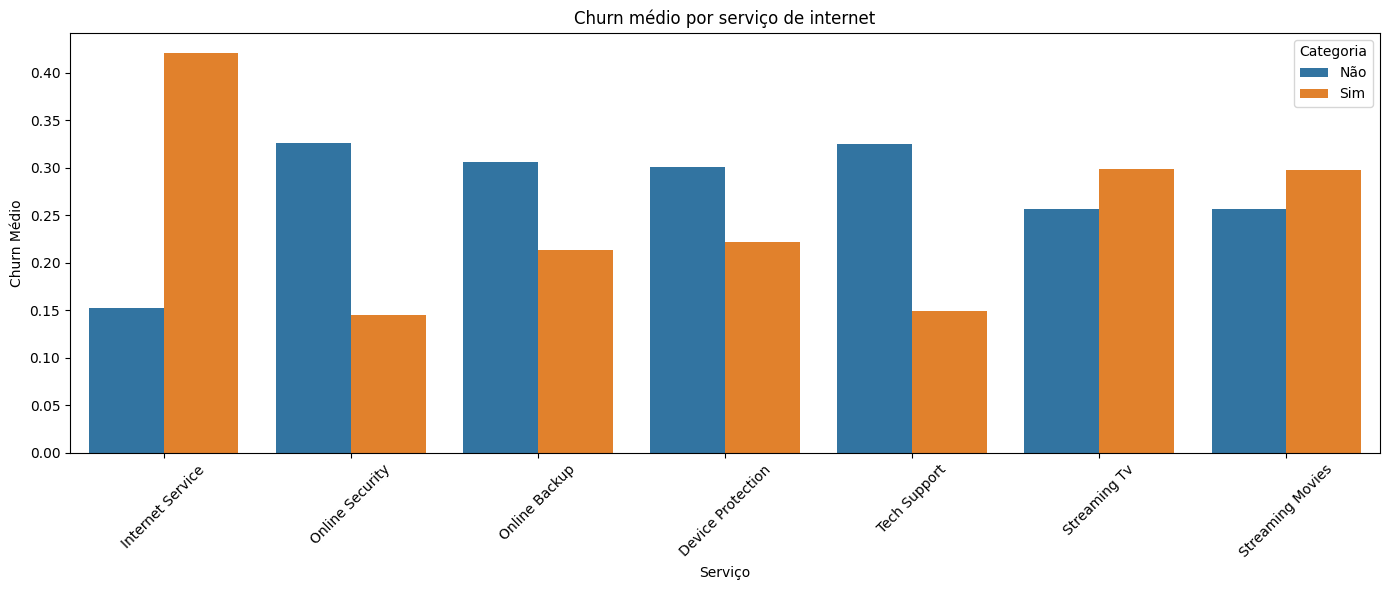

In [59]:
internet_cols = [
    'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'
]

dados_plot = []

for col in internet_cols:
    churn_por_categoria = filtered_df.groupby(col)['is_client'].mean()
    for valor, media in churn_por_categoria.items():
        dados_plot.append({
            'Serviço': col.replace('_', ' ').title(),
            'Categoria': 'Sim' if valor == 1 else 'Não',
            'Churn Médio': 1 - media
        })

plot_df = pd.DataFrame(dados_plot)

plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df, x='Serviço', y='Churn Médio', hue='Categoria')
plt.title('Churn médio por serviço de internet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As pessoas que usam o serviço de internet saem muito mais do que as que não usam. Isso indica que o serviço de internet da companhia talvez não seja tão bom. Uma avaliação ou uma pesquisa pra entender a satisfação dos clientes com esse serviço poderia ser uma boa ideia. A segurança online se mostra mais eficiente. Quem usa tende a ficar bem mais do que aqueles que não usam. Online backup e device protection seguem mais ou menos a mesma linha, apesar de os valores serem mais próximo. Quem conta com esses serviços tem uma tendência um pouco maior de ficar.

O suporte técnico da empresa também parece bom de forma geral, porque quem usa fica bem mais do que quem não usa. Agora, os streeamings são um problema. Aqueles que tem o serviço saem mais do que os que não usam. Vale revisitar catálogos e preços para entender porque os concorrentees parecem levar a melhor aqui. Estabilidade geral do serviço é um fator que pode impactar a internet e o streaming, os dois tipos de serviço com mais taxa de churn. 

Para os mdelos, internet_service parece ter mais peso, mas julgo que essa diferença não é grande o suficiente para gerar desequilíbrio. 

### Linhas Múltiplas

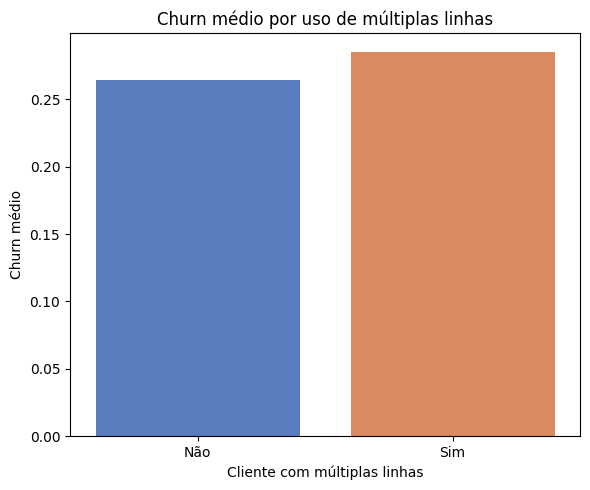

In [60]:
churn_phone = (
    filtered_df
    .groupby('multiple_lines')['is_client']
    .apply(lambda x: 1 - x.mean())
    .reset_index()
)

churn_phone['multiple_lines'] = churn_phone['multiple_lines'].map({0: 'Não', 1: 'Sim'})

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.barplot(
    data=churn_phone,
    x='multiple_lines',
    y='is_client',
    palette='muted'
)

plt.title('Churn médio por uso de múltiplas linhas')
plt.xlabel('Cliente com múltiplas linhas')
plt.ylabel('Churn médio')
plt.tight_layout()
plt.show()

Aqui, seu eu tivesse que ter apostado sem ver o gráfico, perderia. Achei que mais linhas gerriam mais dependência e um envolvimento mais com a empresa, mas clientes com multiplas linhas saem até mais do que os clientes com uma linh só. Comportamento curioso, mas, além disso, bem equilibrado. É dif´cil de imaginar que essa variável terá um grande poder nos estudos do modelo.

### Correlação

In [61]:
colunas_numericas = filtered_df.select_dtypes(include='number')

correlacoes = colunas_numericas.corr()

correlacoes_is_client = correlacoes['is_client'].drop('is_client')

correlacoes_ordenadas = correlacoes_is_client.reindex(correlacoes_is_client.abs().sort_values(ascending=False).index)

print(correlacoes_ordenadas)

time_of_contract_years    0.402339
internet_service         -0.300282
total_charges             0.234312
online_security           0.185700
tech_support              0.180770
monthly_charges          -0.176322
senior_citizen           -0.147230
online_backup             0.099697
device_protection         0.085677
streaming_tv             -0.046591
streaming_movies         -0.044303
multiple_lines           -0.022929
gender                    0.005839
Name: is_client, dtype: float64


In [62]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cat_cols = filtered_df.select_dtypes(include=['object', 'bool']).columns.tolist()

cramers_v_results = {
    col: cramers_v(filtered_df[col], filtered_df['is_client'])
    for col in cat_cols
}

cramers_v_series = pd.Series(cramers_v_results).sort_values(ascending=False)
print(cramers_v_series)

type                 0.441102
payment_method       0.311272
paperless_billing    0.187532
dependents           0.171436
partner              0.170372
dtype: float64


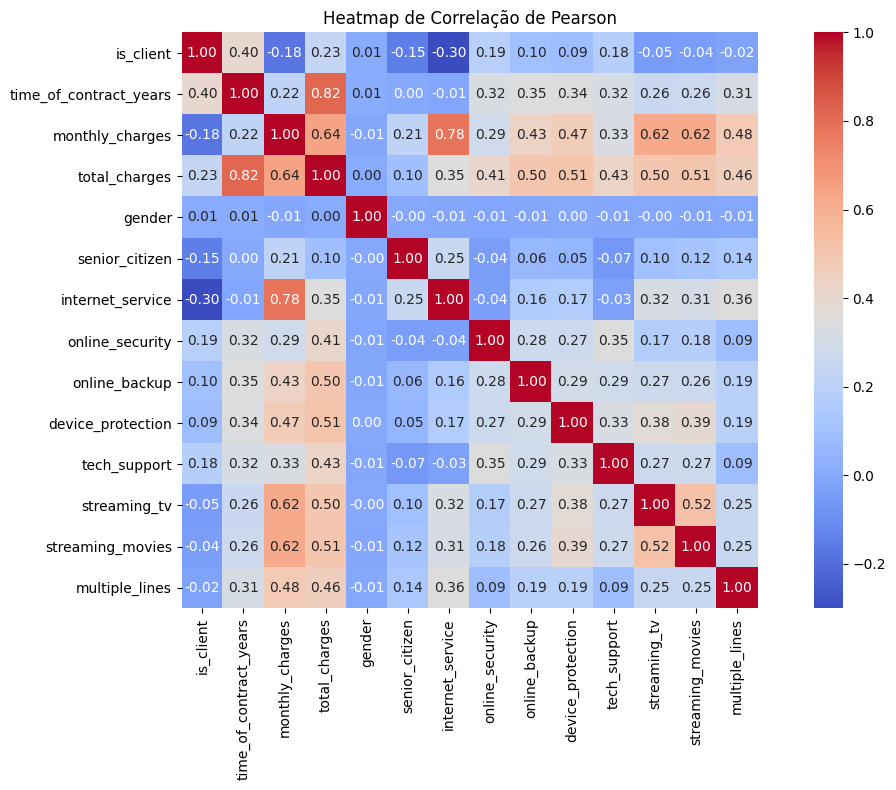

In [63]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlacoes, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap de Correlação de Pearson")
plt.tight_layout()
plt.show()

Cálculamos a correlação de pearson e o gráfico nos retorna os valores que já havíamos avaliado. Temos um modelo com as correlações bem equilibradas, o que nos mostra que não precisaremos alterar pesos de colunas

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    cramers_v_series.to_frame(name='Cramér\'s V'),
    annot=True, cmap='YlGnBu', cbar=False,
    fmt=".2f", linewidths=0.5
)

plt.title('Heatmap de Correlação de Cramér\'s V (variáveis categóricas)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Com isso, temos os resultados das correlações. Vimos aqui que algumas colunas terão importancia razoável para a predição dos nossos modelos, mas fica claro que a variável target não tem correlação muito forte com nenhuma outra, o que é bom para nós.
time_of_contract_years,internet_service , type e payment_method serão as mais importantes. Mas, no mais, podemos seguir em frente

### Conclusão  da AED

Terminamos aqui a etapa de pré processamento e EAD dos dados. Foi bem trabalhoso, mas acredito que temos um resultado bem completo, com insights interessantes para a empresa e comentários sobre o impacto dos dados para os modelos que vamos treinar. 

## Próximos Passos

Aqui, pelo que eu entendi do projeto, é importante deixar uma lista do que eu acredito que sejam os próximos passos, para o Felipe Coutinho avaliar. E estou planejando entrar numa fase de preparação dos dados para os modelos, onde vou:

- Aplicar escalonamento nas variáveis numéricas
- Utilizar One-Hot Encoding para variáveis categóricas
- Verificar o desbalanceamento na variável target
- Dividir os Dados em Conjuntos

Depois, minha ideia é treinar os seguintes modelos:

- Regrssao logistica, 
- Randon_forest, 
- Arvore de decisão, 
- cat_boost, 
- xg_boost

Nessa etapa, eu pretendo aplicar a validação cruzada e o gridsearch para afiar o treinmento e encontrar os melhores parâmetros para cada modelo. Assim, buscamos atingir o melhor AUC-ROC possível. 

### Dúvidas

Não fiquei com muuuitas dúvidas até aqui, mas queria saber a sua análise de tudo o que fiz nessa etapa. Essa preparação de Dados e essa EAD estão boas? Faltou alguma coisa? O tamanho do projeto está dentro do que você esperava?

Usei o gpt pros códigos. Precisei lidar com todos os tradicionais problemas e erros de lógica que ele acaba gerando e acho que fiz isso bem feito. O que voc~e achou da estrutura? Os códigos estão bem estruturados como vc esperava? Há algum problema como redundância ou sei lá?

Vi que temos um ponto extra a ganhar, que, pelo que eu entendi, vem do uso da acurácia como métrica secundária. Qual o valor que precismaos atingir pra garantir esse ponto?

Há mais alguma coisa que vc acha que eu preciso melhorar?

In [65]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6784 entries, 1 to 7042
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   begin_date              6784 non-null   datetime64[ns]
 1   is_client               6784 non-null   int64         
 2   time_of_contract_years  6784 non-null   float64       
 3   type                    6784 non-null   object        
 4   paperless_billing       6784 non-null   bool          
 5   payment_method          6784 non-null   object        
 6   monthly_charges         6784 non-null   float64       
 7   total_charges           6784 non-null   float64       
 8   gender                  6784 non-null   int64         
 9   senior_citizen          6784 non-null   int64         
 10  partner                 6784 non-null   bool          
 11  dependents              6784 non-null   bool          
 12  internet_service        6784 non-null   int64   

In [67]:
df.to_csv('dataframe_filtrado_projeto_final.csv', index=False)

In [68]:
teste = pd.read_csv('dataframe_filtrado_projeto_final.csv')

In [69]:
teste.head()

,begin_date,is_client,time_of_contract_years,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,2017-04-01,1,2.84,One year,False,Mailed check,56.95,1889.50,1,0,False,False,0,1,0,1,0,0,0,0
1,2019-10-01,0,0.17,Month-to-month,True,Mailed check,53.85,108.15,1,0,False,False,0,1,1,0,0,0,0,0
2,2016-05-01,1,3.76,One year,False,Bank transfer (automatic),42.30,1840.75,1,0,False,False,0,1,0,1,1,0,0,0
3,2019-09-01,0,0.17,Month-to-month,True,Electronic check,70.70,151.65,0,0,False,False,1,0,0,0,0,0,0,0
4,2019-03-01,0,0.67,Month-to-month,True,Electronic check,99.65,820.50,0,0,False,False,1,0,0,1,0,1,1,1
